#**Weeds Detection**



---
### Realised by :EL-ALAOUI Ali & HAKEM Adnane



### Load a dataset

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import math

In [ ]:
pip install tensorflow_datasets -U

Requirement already up-to-date: tensorflow_datasets in /usr/local/lib/python3.6/dist-packages (4.2.0)


In [ ]:
data_train, info = tfds.load("deep_weeds", with_info=True, split='train[:60%]',as_supervised=True)
data_valid  = tfds.load("deep_weeds",split='train[60%:80%]',as_supervised=True)
data_test = tfds.load("deep_weeds", split='train[80%:]',as_supervised=True)


Dataset deep_weeds downloaded and prepared to /root/tensorflow_datasets/deep_weeds/3.0.0. Subsequent calls will reuse this data.


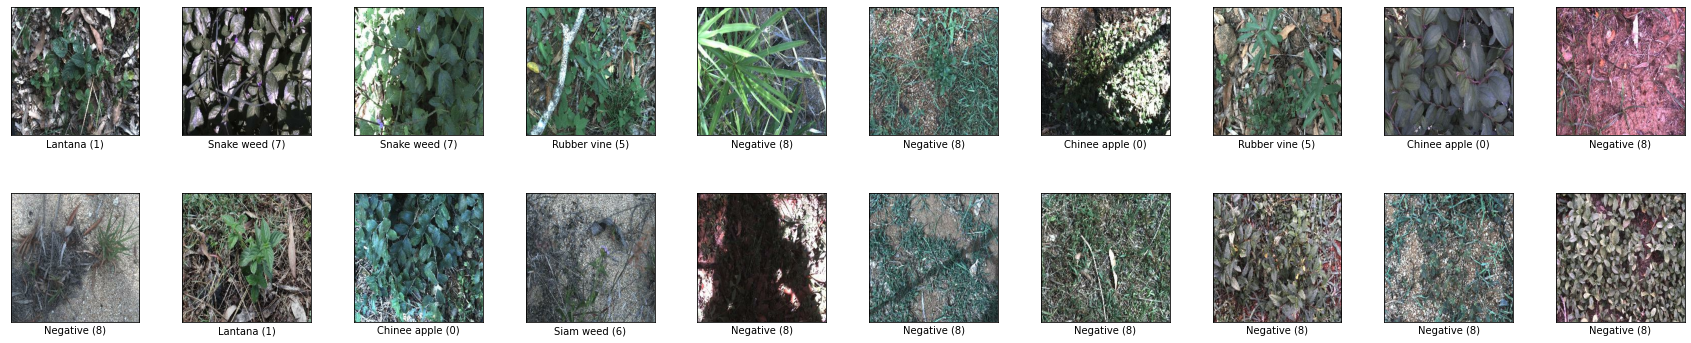

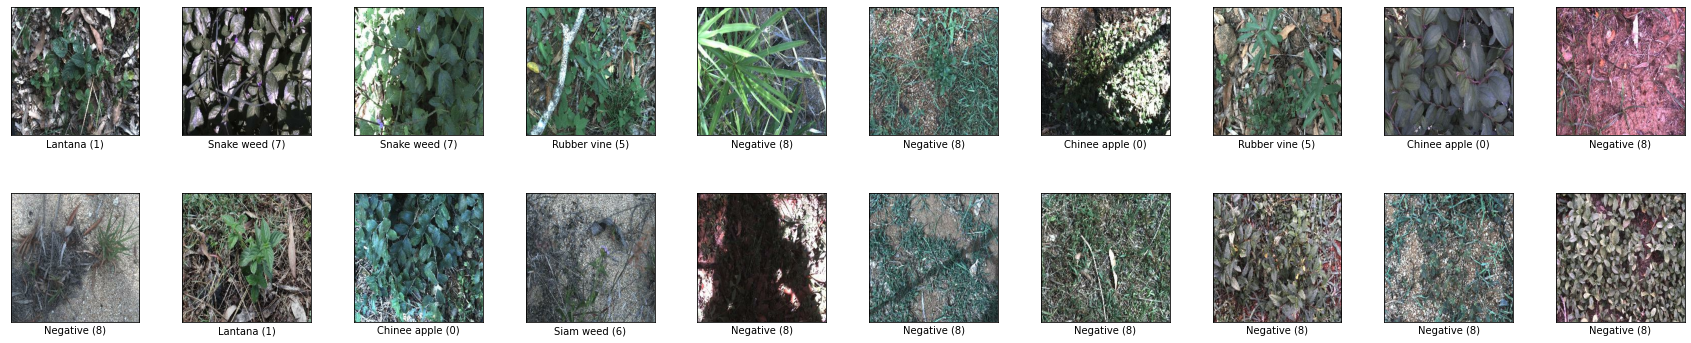

In [ ]:
# A preview of the images in the dataset

tfds.show_examples(data_train, info, rows=2, cols=10)

### Access the dataset metadata
All builders include a tfds.core.DatasetInfo object containing the dataset metadata.

In [ ]:
builder = tfds.builder('deep_weeds')
info = builder.info
print(info)

In [ ]:
info.features

In [ ]:
print(info.features["label"].num_classes)
print(info.features["label"].names)

### data preprocessing

The function below scales pixel values between 0 and 1 and converts to the (data, label) format that keras expects.

In [ ]:
batch_size = 32
IMG_SIZE=224
AUTOTUNE = tf.data.experimental.AUTOTUNE
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])/ 255.0
  #image = (image / 255.0)
  return image, label

def augment(image_label, seed):
  image, label = image_label
  image, label = resize_and_rescale(image, label)

  # image = zoom([image])
  # Random brightness
  image = tf.image.random_brightness(image, max_delta=0.5)
  # random hoeizontal flip
  image = tf.image.random_flip_left_right(image)
  # random vertical flip
  image = tf.image.random_flip_up_down(image)
  # random shiffting of the channels
  image = tf.image.random_hue(image, max_delta=0.1)
  # Adjust contrast
  image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
  #random rotation
  delta = tf.random.uniform([], minval = math.radians(-360), maxval = math.radians(360), dtype=tf.float32)
  image = tf.image.rot90(image, tf.dtypes.cast(delta, tf.int32))
  # random zoom hack 
  # since the image is 224x224 px we gonna crop it randomly between 70~200 px
  crop_size = tf.random.uniform([], minval = 70 ,maxval = 200, dtype=tf.float32) #generate random crop size
  image = tf.image.random_crop(image, [crop_size,crop_size,3], seed=None, name=None)
  image = tf.image.resize(image, [224,224], method = tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=False,antialias=False, name=None)
  
  return image, label

In [ ]:
# Create counter and zip together with train dataset
counter = tf.data.experimental.Counter()
train_aug = tf.data.Dataset.zip((data_train, (counter, counter)))

train_aug= (
   train_aug.cache().map(augment, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE))

      
val_aug =(
    data_valid.cache().map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(32)
    .prefetch(AUTOTUNE)
)

test_aug = (
    data_test.cache().map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(32)
    .prefetch(AUTOTUNE))



We can now train an image classifier. I use ResNet50 as the base because that’s what was used in the deep weeds paper. The paper trained an image classifier to achieve 95% accuracy on the validation set.

In [ ]:
import keras
from keras.layers import Input, Dense, Flatten,GlobalAveragePooling2D,Dropout
from keras.models import Model, load_model
from keras import Sequential
from keras.optimizers import RMSprop,Adam,SGD
from keras.applications import ResNet50, InceptionV3
from livelossplot import PlotLossesKeras
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

In [ ]:

NUM_EPOCHS =100
INIT_LR =lr=0.0001
image_input = Input((224,224,3))
resnet =ResNet50(include_top=False, weights="imagenet")
resnet_50 =ResNet50(input_shape=(224, 224,3),include_top=False, weights="imagenet")

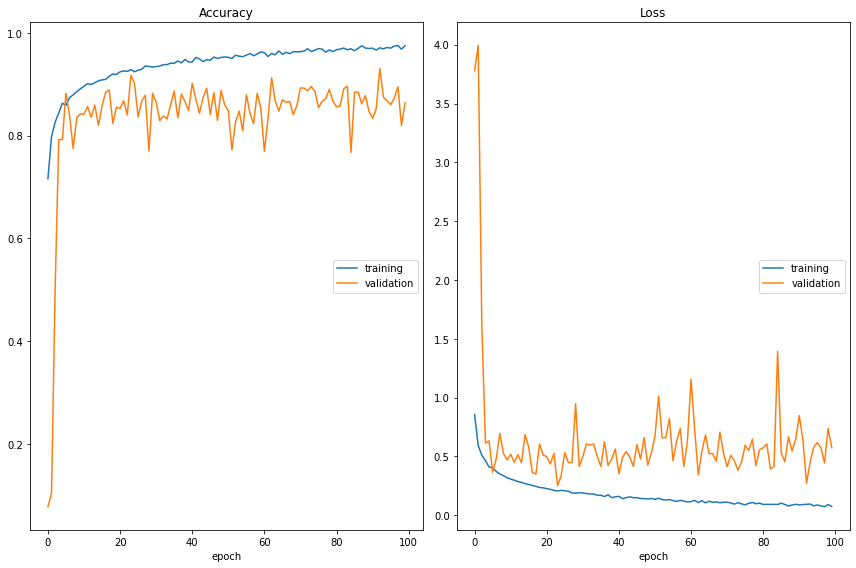

Accuracy
	training         	 (min:    0.716, max:    0.976, cur:    0.975)
	validation       	 (min:    0.077, max:    0.931, cur:    0.864)
Loss
	training         	 (min:    0.073, max:    0.856, cur:    0.076)
	validation       	 (min:    0.253, max:    3.993, cur:    0.574)

Epoch 00100: val_acc did not improve from 0.07738


In [ ]:

model_res=Sequential()
#Add the Dense layers along with activation and batch normalization
model_res.add(resnet_50)
model_res.add(GlobalAveragePooling2D())
model_res.add(Flatten())
model_res.add(Dense(9,activation='softmax'))
model_res.compile(optimizer=Adam(INIT_LR),loss="sparse_categorical_crossentropy",metrics="acc")
my_callbacks = [PlotLossesKeras(),
    #ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=32, min_lr=0.00000001),
    #tf.keras.callbacks.EarlyStopping(patience=32,restore_best_weights=True),
    ModelCheckpoint(filepath="/content/drive/MyDrive/Colab Notebooks/model_resnet50.hdf5",mode='min', monitor='val_acc', verbose=2, save_best_only=True)
      ]
print(model_res.summary())    
history=model_res.fit(train_aug,epochs=100,callbacks=my_callbacks,validation_data=val_aug)

In [ ]:
model_res.save("/content/drive/MyDrive/Colab Notebooks/models_DL/resnet50.hdf5")

#Model evaluation

In [ ]:
model_res.evaluate(test_aug)

110/110 [==============================] - 6s 55ms/step - loss: 0.6578 - acc: 0.8532


[0.65780109167099, 0.8532267212867737]

In [ ]:
var_pred=model_res.predict(test_aug)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.metrics import confusion_matrix

# predicted ones
val_preds = np.argmax(var_pred, axis=1)

# true ones
val_trues = np.array([label[1].numpy() for _, label in enumerate(data_test)])

weeds_label = ["Chinee apple", "Lantana", "Parkinsonia", "Parthenium", "Prickly acacia", "Rubber vine", "Siam weed", "Snake weed", "Negatives"]
print(val_preds)
print(val_trues) 
print(classification_report(val_trues,val_preds,target_names=weeds_label))

[2 1 0 ... 1 8 6]
[2 8 0 ... 8 8 6]
                precision    recall  f1-score   support

  Chinee apple       0.81      0.67      0.73       234
       Lantana       0.69      0.91      0.78       211
   Parkinsonia       0.96      0.80      0.87       213
    Parthenium       0.65      0.88      0.74       203
Prickly acacia       0.69      0.96      0.80       217
   Rubber vine       0.96      0.85      0.90       200
     Siam weed       0.91      0.83      0.87       218
    Snake weed       0.86      0.78      0.82       235
     Negatives       0.92      0.87      0.90      1771

      accuracy                           0.85      3502
     macro avg       0.83      0.84      0.82      3502
  weighted avg       0.87      0.85      0.86      3502



# **using inceptionv3**

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
inception_model = InceptionV3(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

87916544/87910968 [==============================] - 0s 0us/step


In [ ]:
 def scheduler(epoch, lr):
    if epoch < 10:
       return lr
    else:
         return lr * tf.math.exp(-0.1)

In [ ]:
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import LearningRateScheduler

x = layers.Flatten()(inception_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(9, activation='sigmoid')(x)

model = tf.keras.models.Model(inception_model.input, x)
my_callbacks = [
    PlotLossesKeras(),
  LearningRateScheduler(scheduler),
    #tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, min_lr=1e-8),
    #tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/Colab Notebooks/models_DL/Weeds_Detection_model_incep150.hdf5",mode='max', monitor='val_acc', verbose=2, save_best_only=True)
      ]
model.compile(optimizer = RMSprop(lr=0.0001), loss = "sparse_categorical_crossentropy", metrics = ['acc'] )

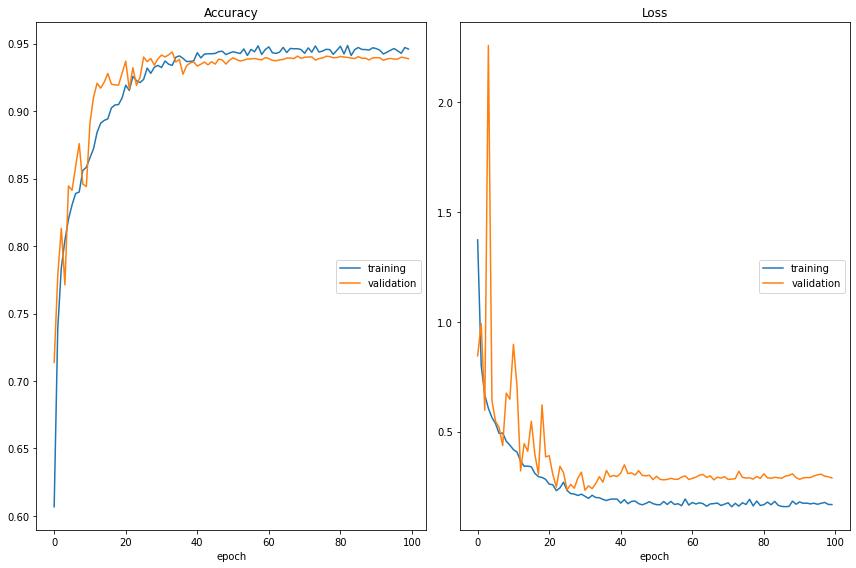

Accuracy
	training         	 (min:    0.607, max:    0.949, cur:    0.946)
	validation       	 (min:    0.714, max:    0.944, cur:    0.939)
Loss
	training         	 (min:    0.158, max:    1.374, cur:    0.167)
	validation       	 (min:    0.233, max:    2.260, cur:    0.288)

Epoch 00100: val_acc did not improve from 0.94374


In [ ]:
inc_history = model.fit(train_aug, validation_data = val_aug,callbacks=my_callbacks,epochs = 100)

In [ ]:
scores=model.evaluate(test_aug)

110/110 [==============================] - 8s 68ms/step - loss: 0.4643 - acc: 0.9015


In [ ]:
#model.save("/content/drive/MyDrive/Colab Notebooks/models_DL/inseptionV3.txt")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/models_DL/inseptionV3.txt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/models_DL/inseptionV3.txt/assets


In [ ]:
mod_inseptionV3_100=load_model("/content/drive/MyDrive/Colab Notebooks/models_DL/inseptionV3.txt")
var_pred=mod_inseptionV3_100.predict(test_aug)

In [ ]:
var_pred

array([[2.9428054e-05, 8.4401845e-06, 9.9999702e-01, ..., 9.6379204e-05,
        3.0708211e-06, 5.6168877e-02],
       [2.6072451e-01, 5.6102371e-01, 4.3127076e-03, ..., 4.9305975e-02,
        1.1384388e-01, 8.8959408e-01],
       [9.9930894e-01, 5.1657995e-03, 9.6009535e-05, ..., 4.1585474e-05,
        4.9200210e-01, 3.5230896e-01],
       ...,
       [6.8156444e-03, 6.5731233e-01, 1.2255043e-05, ..., 4.1056683e-04,
        3.4081072e-02, 9.9575138e-01],
       [1.8425913e-20, 6.1544849e-29, 0.0000000e+00, ..., 0.0000000e+00,
        1.3876758e-35, 1.0000000e+00],
       [4.8159645e-06, 1.0565088e-04, 6.2614763e-10, ..., 9.9999022e-01,
        4.2123925e-03, 7.7365868e-05]], dtype=float32)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.metrics import confusion_matrix

# predicted ones
val_preds = np.argmax(var_pred, axis=1)

# true ones
val_trues = np.array([label[1].numpy() for _, label in enumerate(data_test)])

weeds_label = ["Chinee apple", "Lantana", "Parkinsonia", "Parthenium", "Prickly acacia", "Rubber vine", "Siam weed", "Snake weed", "Negatives"]
print(val_preds)
print(val_trues) 
print(classification_report(val_trues,val_preds,target_names=weeds_label))

[2 8 0 ... 8 8 6]
[2 8 0 ... 8 8 6]
                precision    recall  f1-score   support

  Chinee apple       0.82      0.74      0.78       234
       Lantana       0.89      0.91      0.90       211
   Parkinsonia       0.95      0.90      0.92       213
    Parthenium       0.89      0.81      0.85       203
Prickly acacia       0.78      0.93      0.84       217
   Rubber vine       0.97      0.90      0.93       200
     Siam weed       0.92      0.91      0.91       218
    Snake weed       0.79      0.83      0.81       235
     Negatives       0.93      0.94      0.94      1771

      accuracy                           0.90      3502
     macro avg       0.88      0.87      0.88      3502
  weighted avg       0.90      0.90      0.90      3502

